# GPU Accelerated solution of Poisson problems
by Henry Atkins

In [ ]:
import numba
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import cuda
%matplotlib inline
###################################################################################
#Useful Functions
def u_deriv_calc(x,y):
  """This returns a single float from 2 input floats 
  following the derivative function (g)."""
  return -((2*x - 1)**2 + (2*y - 1)**2 + 4)*
  (np.exp((y - 0.5)**2 + (x - 0.5)**2))

def u_exact_calc(x,y):
  """This returns a single float from 2 input floats 
  following the function (f)."""
  return np.exp((y - 0.5)**2 + (x - 0.5)**2)

def plot(Z, title, comparison, N):
  """Takes a Z axis, and plots it againt the x,y unit square 
  with string input title."""
  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca(projection='3d')
  ticks = np.linspace(0, 1, N)
  x, y = np.meshgrid(ticks, ticks)
  ax.set_xlabel("X Axis 0-1")
  ax.set_ylabel("Y Axis 0-1")
  ax.set_zlabel("Function Axis")
  plt.title(title)
  surf = ax.plot_surface(x, y, Z, antialiased=True, cmap=cm.coolwarm)
  plt.show()
  if comparison == True:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')
    ticks = np.linspace(0, 1, N)
    ax.set_xlabel("X Axis 0-1")
    ax.set_ylabel("Y Axis 0-1")
    ax.set_zlabel("Function Axis")
    x, y = np.meshgrid(ticks, ticks)
    plt.title("Exact Function on the Unit Square")
    surf = ax.plot_surface(x, y, np.exp((y - 0.5)**2 + (x - 0.5)**2), 
                           antialiased=True, cmap=cm.coolwarm)
    plt.show()
  return

def error_calc(u, target):
  """Relative error between source functions, with no 0 divisions."""
  return (np.linalg.norm(u-target)/np.linalg.norm(target+1e-16).max())

def get_exact_vector(N):
  """Calculated the exact values of function f for size N."""
  N_exact = np.empty(N*N)
  ticks = np.linspace(0, 1, N)
  x, y = np.meshgrid(ticks, ticks)
  N_exact = np.exp((y - 0.5)**2 + (x - 0.5)**2)
  return N_exact

################################################################################

def discretise(N, func_f, func_g):
    """Generates the matrix and rhs associated with the discrete Poisson operator Af=u.
    Adapted from the Lecture notes. A is a Sparse CSR matrix"""
    nelements = 5 * N**2 - 16 * N + 16
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            data[count] =  1
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                f[j * N + i] = func_f(i/N , j/N) #This was 0
                count += 1
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i   
                data[count] = 4*((N + 1)**2)
                data[count + 1 : count + 5] = - (N + 1)**2
                f[j * N + i] = func_g(i/N , j/N) # This was 1
                count += 5
    A = coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr()                                
    return A.tocsr(), f

def grid_discretise(N, func_f, func_g):
  """Discretizes across the unit square from functios f,g"""
  u, f = np.zeros(((N)**2)), np.zeros(((N)**2))
  x, y = np.linspace(0,1, N), np.linspace(0,1, N)
  for i in range(N):
      for j in range(N):
        if i == 0 or i == N - 1 or j == 0 or j == N - 1:
          u[i * (N) + j] = func_g(x[i], y[j])
          f[i * (N) + j] = 0
        else:
          u[i * (N) + j] = 0
          f[i * (N) + j] = func_f(x[i], y[j])
  return u, f

def find_solution(N, max_iterations, tolerance, func_f, func_g, text):
  """Takes f, g, tolerance and N. Returns Approximated solution u with the exact solution,
  list of errors at each iteration and iteration count to solution. 
  Text param gives more readouts and info on running."""
  u_exact = get_exact_vector(N)
  u_k, fi = grid_discretise(N, func_f, func_g)
  error_list = []
  error_i = 1
  iter_to_converge = 0
  while error_i > tolerance:
    u_k1 = np.zeros(N**2)
    iter_to_converge += 1
    u_k1 = single_iteration(N, u_k, u_k1, fi)
    error_i = error_calc(u_k1, u_k)
    error_list.append(error_i)
    if iter_to_converge == max_iterations:
      print("NOT ENOUGH ITERATIONS...GIVE ME MORE NUMBERS!!")
      return(u_k1, u_exact, error_list, iter_to_converge)
    else:
      u_k = u_k1
      pass
  if text==True:
    print("Solved ", N,"x", N,"Matrix to a tolerance of", tolerance, 
          "% in ", iter_to_converge, " Iterations.")
  return(u_k1, u_exact, error_list, iter_to_converge)

def single_iteration(N, u_k, u_k1, fi):
  """Single iteration of uk -> uk+1 obeying the iterative equation."""
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N - 1 or j == 0 or j == N - 1: 
         u_k1[i*N + j] = u_k[i*N + j]
      else:
        up = u_k[(i-1)*N + j]
        down = u_k[(i+1)*N + j]
        left = u_k[i*N + (j-1)]
        right = u_k[i*N + (j+1)]
        u_k1[i*N + j] = 0.25*(fi[i*N + j]/((N+1)**2)  + up + down + left + right)
  return u_k1

def find_GPU_solution(N, max_iterations, tolerance, func_f, func_g, text):
  """RUNS ON GPU (NOT USED) Takes f, g, tolerance and N. Returns Approximated 
  solution u with the exact solution, list of errors at each iteration and 
  iteration count to solution. Text param gives more readouts and info on running."""
  u_exact = get_exact_vector(N)
  u_k, fi = grid_discretise(N, func_f, func_g)
  error_i = 1
  iter_to_converge = 0
  while error_i > tolerance:
    iter_to_converge += 1
    TPB = 16
    BPG = (N+TPB-1)//TPB
    GPU_u = cuda.to_device(u_k)
    GPU_f = cuda.to_device(fi)
    GPU_u1 = cuda.device_array(shape=(N)**2)

    single_GPU_iteration[(BPG,1), (TPB, 1)](GPU_u,GPU_f, GPU_u1, N)
    u_k1 = GPU_u1.copy_to_host()
    print(u_k1)
    error_i = error_calc(u_k1, u_k)
    if iter_to_converge == max_iterations:
      print("NOT ENOUGH ITERATIONS...GIVE ME MORE NUMBERS!!")
      return(u_k1, u_exact, error_i, iter_to_converge)
    else:
      u_k = u_k1
      pass
  if text==True:
    print("Solved ", N,"x", N,"Matrix to a tolerance of", tolerance, "% in ", 
          iter_to_converge, " Iterations.")
  return(u_k1, u_exact, error_i, iter_to_converge)


"""BelowThis is the single iteration on the GPU - each thread runs this once"""
@cuda.jit()
def single_GPU_iteration(u_k, f, u_k1, N):
  j = cuda.grid(1)
  local_u_k = u_k  
  local_u_k1 = u_k1
  local_f = f
  cuda.syncthreads()
  for i in range(N):
    for j in range(N):
      if i == 0 or i == N - 1 or j == 0 or j == N - 1: 
         local_u_k1[i*N + j] = local_u_k[i*N + j]
      else:
        local_u_k1 = local_u_k
        left = local_u_k[i*N + (j-1)]
        right = local_u_k[i*N + (j+1)]
        up = local_u_k[(i-1)*N + j]
        down = local_u_k[(i+1)*N + j]

        local_u_k1[i*N + j] = 0.25*(local_f[i*N + j]/((N+1)**2)  + up + down + 
                                  left + right)
        cuda.syncthreads()
      local_u_k = local_u_k1

The goals of this coursework are threefold:

1) Establish whether Poisson Problems may be solved via a Discretization method,

2) establish whether Poisson Problems may be solved via a Iterative Method,

3) adapt the Iterative Method to a GPU for faster solutions.

The system of equations we will be solving is below, 
with the numerical example (called the source function from now) below it.

The Differential Equation we will solve:

$-\Delta u(x,y) = f(x,y)$

The Source Function we will be solving: 

$u(x,y) = \mathrm{e}^{\left(x-\frac{1}{2}\right)^2+\left(y-\frac{1}{2}\right)^2}$

-$\Delta[\mathrm{e}^{\left(x-\frac{1}{2}\right)^2+\left(y-\frac{1}{2}\right)^2}]$ = 
$-\left(\left(2x-1\right)^2\left(2y-1\right)^2 + 4\right)\mathrm{e}^{\left(y-\frac{1}{2}\right)^2+\left(x-\frac{1}{2}\right)^2}$

In solving this function, Boundary Conditions (BC) will be used. These are as follows:

$g(x,y) = u_{BC}(x,y) = \mathrm{e}^{\left(x-\frac{1}{2}\right)^2+\left(y-\frac{1}{2}\right)^2}$


# Proving the function can be appoximated by Discretization. 

A continuous function may be discretized by superposing the function over a discrete grid, and calculating a function value at each point of the grid, each point being a defined step-size apart. For example, f(0,0.1) would be calculated at point (x=0,y=0.1). This gives us a 3D function which we may plot or calculate error from.

To do this, the below equation is used at each point. 

$-\Delta u \approx \frac{1}{h^2} [4u(x_{i},y_{j}) - u(x_{i-1},y_{j}) - 
u(x_{i+1},y_{j}) - u(x_{i},y_{j-1}) - u(x_{i},y_{j+1})] $

This equation is of the form $Au = f$, (where $f=-\Delta u$, A is a NxN matrix and $h = \frac{1}{N+1}$ is the step size) which can be solved for u, which is our solution.

The below cell discretizes the function and plots it onto the unit square. This shows whether the method is valid for large scale solving of Poisson equations. By calculating the function value at 250,000 points within the square, the error is calculated. 

Relative Error between Discretized and Exact Calculation is :  0.12162618730433407 %


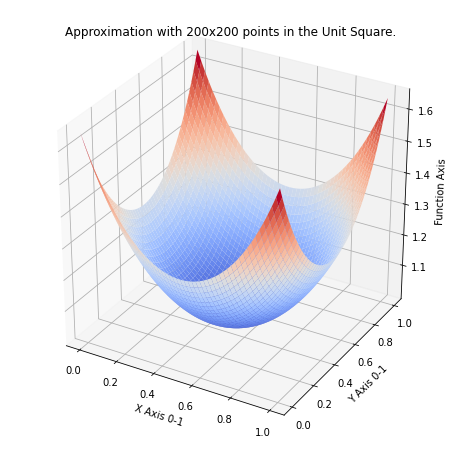

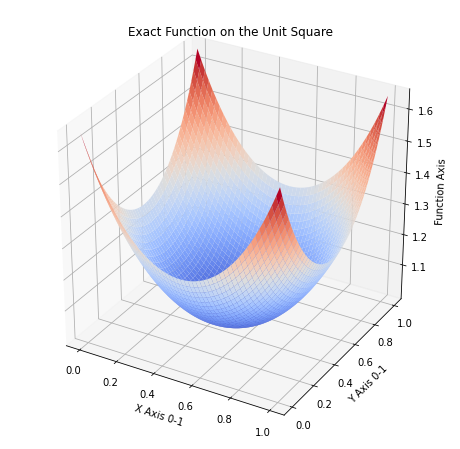

In [ ]:
N = 500

u_exact = get_exact_vector(N)
A, f = discretise(N, u_exact_calc, u_deriv_calc)  #retrieving A, f to solve for u 
sol = spsolve(A, f)                         #Sparse solver as A is sparse and CSR
u = A.dot(sol) 
u, u_exact = sol.reshape((N, N)), u_exact.reshape((N, N))

print("Relative Error between Discretized and Exact Calculation is : ", 
      100*error_calc(u, u_exact),"%")
plot(u, "Approximation with 200x200 points in the Unit Square.", True, N)

As you can see, the approximation is accurate to within 0.12%, validating the use of the discretization method to solve Poisson systems. But, how does the matrix size affect the error?

# Task 1: 
##Errors and Number of Elements

In calculating these discretizations the matrix equation Af = u is used. Because matrix A is NxN size, $A \propto  N^2$ so the number of calculations to discretize, calculate and solve increases exponentially. While this increases calculation times, the smaller $\downarrow h = \frac{1}{\uparrow N+1} \propto  Error\downarrow$ means less interpolation. This means the error will fall, while sacrificing computation time. 

This next section discusses how the error associated with the discretized method changes with N. As h shrinks in 2-Dimensions, we belive the error willl fall with $N^2$ so the Error will be represented with the Log(Error), and N will also be Log(N) as this will aim to cover 3 orders of magnitude (O=1,10,100). The  N values will double from 4 until 512, and the error is appended to a list at each N.

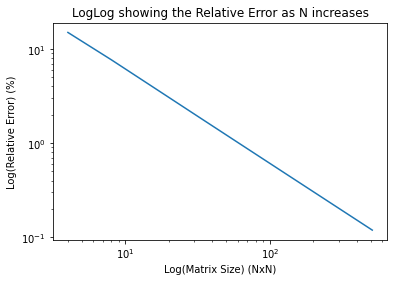

In [ ]:
Ns = [4, 8, 16, 32, 64, 128, 256, 512]
error = []

for i in (Ns):
  u_exact = get_exact_vector(i)
  A, f = discretise(i, u_exact_calc, u_deriv_calc)
  sol = spsolve(A, f)
  u = A.dot(sol)
  u, u_exact = sol.reshape((i, i)), u_exact.reshape((i, i))
  error.append(100*error_calc(u, u_exact))
plt.title("LogLog showing the Relative Error as N increases")
plt.xlabel("Log(Matrix Size) (NxN)")
plt.ylabel("Log(Relative Error) (%)")
plt.loglog(Ns, error)

As expected, the LogLog Error graph is a negative gradient straight line as N increases. This shows how the error falls in 2 Dinensions and contributes to a squared reduction in relative error. For visualization purposes, below is the same data plotted to show the exponentioal reduction in error.

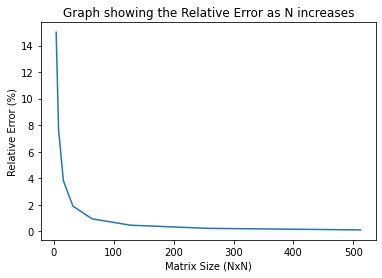

In [ ]:
plt.title("Graph showing the Relative Error as N increases")
plt.xlabel("Matrix Size (NxN)")
plt.ylabel("Relative Error (%)")
plt.plot(Ns, error)

# Task 2:

The second task is seperated into 2 sections, firstly making an iterative solver for the Poisson problem described earlier, and then implementing it into a GPU.

# Iteration:

The Iterative method relies on a rearrangement of the above formula from a discretized method to an iterative form.

$-\Delta u \approx \frac{1}{h^2} [4u(x_{i},y_{j}) - u(x_{i-1},y_{j}) - u(x_{i+1},y_{j}) - u(x_{i},y_{j-1}) - u(x_{i},y_{j+1})] $

becomes

$u^{k+1}(x_{i},y_{j}) = \frac{1}{4}[h^2 f(x_{i},y_{j}) + u^{k} (x_{i-1},y_{j}) + u^{k} (x_{i+1},y_{j}) + u^{k} (x_{i},y_{j-1}) + u^{k} (x_{i},y_{j+1})]$
 

where the second half of the equation 

$u^{k} (x_{i-1},y_{j}) + u^{k} (x_{i+1},y_{j}) + u^{k} (x_{i},y_{j-1}) + u^{k} (x_{i},y_{j+1})$ 

is the average of the above, below, left and right points for point (i,j) in the previous iteration. Adding this to a scalar from the discretized function $f$ approximates the gradient iterativly. 

The first question we will ask is whether this does approximate $-\Delta u = f(x,y)$. The below plot shows how the approximated function looks, as well as displaying the number of iterations required to achieve a tolerance (error) of 0.00001%.  




Solved  50 x 50 Matrix to a tolerance of 1e-06 % in  3559  Iterations.


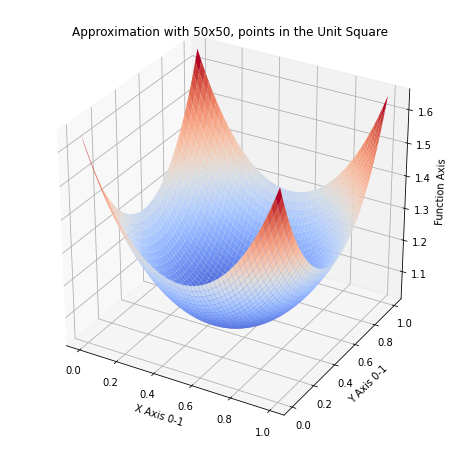

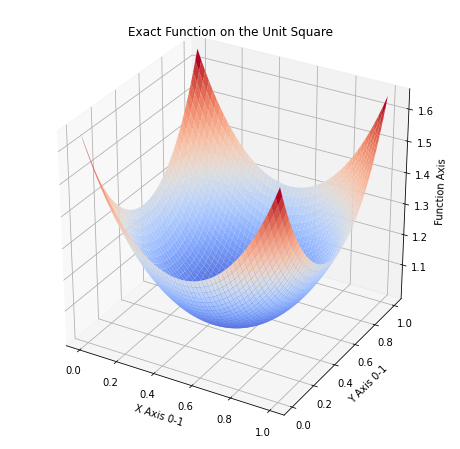

In [ ]:
N = 50
sol = find_solution(N, 100000, 1e-6, u_deriv_calc, u_exact_calc, True)
u_exact = get_exact_vector(N)
plot(sol[0].reshape((N,N)), ("Approximation with "+str(N)+"x"+str(N)+", points 
  in the Unit Square"), True, N)

It is also worth considering how matrix size affects the iterations required to solve, so here matrices of sizes 1 to 100 are tested and the solving iteration recorded. We expect the required iteration to scale exponentially with N. As N increases the number of elements scales like $N^2$ so the required computations scales similarly. As N is larger, there is a larger proportion of elements inside the BC, so the BC will take more iterations to 'average out' the internal points. 

Another way of thinkning about this is that as NxN gets bigger, the number of internal points follows 

$N^o Internal Points = 4(N-1) + 4(N-2)^2 = 4N^2 -12N -12$.

This means that for larger N, each BC has less affect on the internal points. This means that it takes more time for the averages to 'cascade down' into all the elements. 

The quadratic expression leads us to belive that this will be strongly non-linear and will be increasing for increasing N.

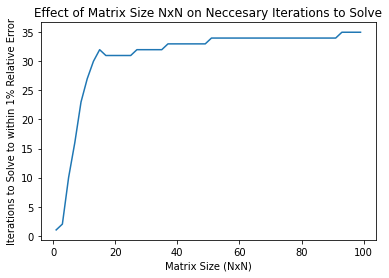

In [ ]:
iter = []
for n in np.arange(1,100,2):
  iter.append(find_solution(n, 1000000, 0.01, u_deriv_calc, u_exact_calc, 
                            False)[3])

plt.title("Effect of Matrix Size NxN on Neccesary Iterations to Solve")
plt.xlabel("Matrix Size (NxN)")
plt.ylabel("Iterations to Solve to within 1% Relative Error")
plt.plot(np.arange(1,100,2), iter)

The results of the above graph are suprising, the graph appears to tend towards a maximum, which we were not expecting. This is possibly linked to the order of magnitudes involved - notice the jump from single digits to double. Below this hypothesis is tested, as one order of magnitude higher (N=1000) is calculated. This is expected to take ~350 iterations. 

The hypothesis is incorrect, as the number of iterations to obtain a solution of a 1000x1000 matrix apears to be 35. While the researcher is suspicious this is a program bug, it seems logical from the above graph. Although this is an interesting point, the iteration requirements are not under scrutiny here, so we will move on.

In [ ]:
find_solution(1000, 1000000, 0.01, u_deriv_calc, u_exact_calc, False)[3]

35

The errors associated with this iterative scheme may be more yielding. It is expected that the error in calculating a matrix will increase as a square similarly to the prediction above for the solving number of iterations. This is for similar reasons linked to scaling. 

This experiment is ran by recording the error after a constant number of iterations, we use 100 in this case.

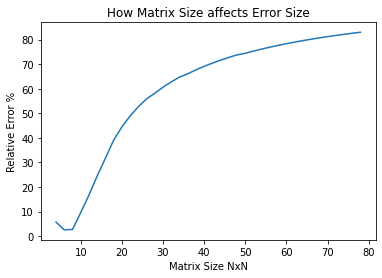

In [ ]:
error_list = []
for i in np.arange(4,80, 2):
  sol = find_solution(i, 100, 0.01, u_deriv_calc, u_exact_calc, False)
  u_exact = get_exact_vector(i)
  error_list.append(100*error_calc(sol[0].reshape((i,i)), u_exact))

plt.xlabel("Matrix Size NxN")
plt.ylabel("Relative Error %")
plt.title("How Matrix Size affects Error Size")
plt.plot(np.arange(4,80, 2), error_list)

As expected, the error increases for a fixed tolerance and iteration length. The relationship is interesting however. The upwards trend is interupted by a lower kink at NxN = 6x6. This is linked to N$<$6 being solved completly by 100 iterations. 

This shows how important the iterations are, with only a 25x25 matrix, 100 iterations cannot clear up 50% of the error.

#Convergence

Convergance is the most important factor of any iterative solver. Convergance is the number of iterations neccessary to solve the sytstem to within a tolerance. Larger matrices will have longer convergance iterations, and so require more computation time. 

Here matrices are used of sizes doubling between 2 and 126. The relative error between iterations is saved and plotted for each. The max_iterations is kept large to allow all the matrices to calculate, and a tolerance of 0.1 % is used. 

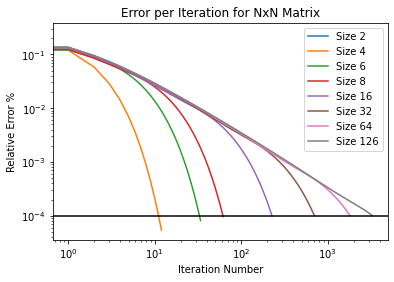

In [ ]:
N_to_test = [2,4,6,8,16,32,64,126]
for Ns in N_to_test:
   plt.loglog(find_solution(Ns, 10000, 0.0001, u_deriv_calc, u_exact_calc, 
                            False)[2], label = ("Size "+str(Ns)))
plt.legend()
plt.title("Error per Iteration for NxN Matrix")
plt.xlabel("Iteration Number")
plt.ylabel("Relative Error %")
plt.axhline(y=1e-4, color='k', linestyle='-')
plt.show()

What is particularly interestong here is that none are above the $y = x^{-a}$ line sloping downwards. This suggests that as N increases they approximate to an exponential decay. The low N matrices are covered much faster than this, but the larger N approximate to a straight line on this LogLog graph (and therefore an exponential in linear graphs). 

# GPU

A Graphics Processing Unit (GPU) is a supplementary compute device we use to speed up calculations. They have many atributes which make them good for high throughput computations. 

The ability to split calculations (loops, threads etc) into many smaller, simultaneous calculations gives us much more power. We can perform faster and larger calculations. This 'mega-parallel' ability comes from the architecture of GPUs. Where a CPU is made of 1-8 cores and a large cache, GPUs have many (100s) cores and little cache memory. This makes then optimized for low memory, repeatable computations. Placing the same logic on every core and then collating the (100s of) results is just as fast as a CPU performing 1-8 of these smaller computations.

Here Numba Cuda is used. This is a C compiled python module which alows us to implement GPU programming into python. The below cell brings up information about the GPU we are accessing via Google Colab. The name 'Tesla K80' corresponds to the model, and the 'compute capibility' corresponds to Colab's assesment of the GPU out of 10.

In [ ]:
cuda.detect()

Found 1 CUDA devices
id 0            b'Tesla K80'                              [SUPPORTED]
                      compute capability: 3.7
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

The next step is to test if the GPU is a valid place to perform these calculations. Can we make a plot similar to the above functions?

The GPU method requires some explaining, so we will explain some parameters and methods.

Threads, Blocks and Grid. The basic stream of a calculation on a GPU is a thread. These are where individual computations occur. In this case each thread replaces $u_k[i,j]$ with the average from the surrounding cells in the previous iteration plus a factor from the gradient function f(x,y). These threads are where the parallel supremecy over CPU comes from. Blocks are how threads are arranged. They organise threads into groups so threads can be organised, computed and worked with. TPB = threads per block, and BPG = Blocks per grid. The grid is the overarching organisation tool in a GPU. Each thread is found by a combination of these indexes. Generally, $Global Index = Thread Index + Block Size \times Block Index$. This allows us to instruct each thread to obey a specific command if we want, or to send one command to many threads as we do here. The BPG and TPB are called by a cuda compiled function in - function$[$(TPB,),(BPG,)$]$(param) - format.

Memory Management. Because the GPU is a seperate compute device, no memory is shared with the CPU. This means that we must pass any data it needs to compute with to each thread, before it begins the calculation. To do this we use cuda.to_device() which passes the variable to the GPU device in an acceptable format. Because threads are so starved for memory, each object they are passed or will work with must have memory pre-allocated. This means specifying the type (dtype=float32) when passing arrays, and creating empty arrays of size=$N^2$ before calculation begins for arrays which will be created by the calculation.

Relative Error is :  23.258335685477075 %


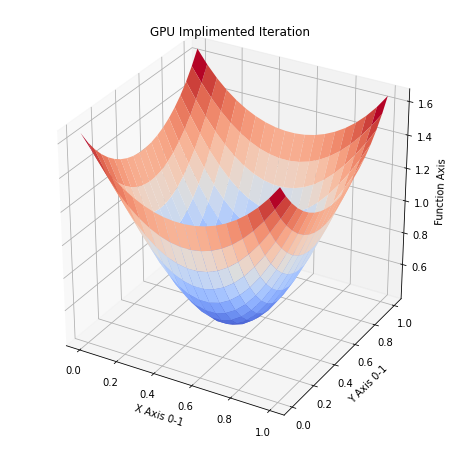

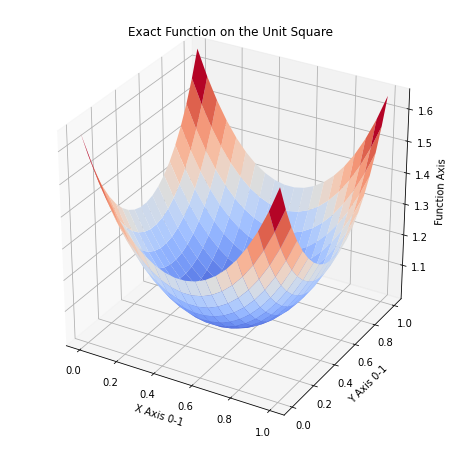

In [ ]:
N = 20
u,f = grid_discretise(N, u_deriv_calc, u_exact_calc) #calling u and f
u_exact = get_exact_vector(N)

#Threads per Block, and Blocks per Grid
TPB = 16
BPG = (N+TPB-1)//TPB

#Loading u,f to GPU memory and allocating memory for u(k+1) cuda accepts 
#single and double precision objects.
u_to_GPU = cuda.to_device(u, dtype=float32)
f_to_GPU = cuda.to_device(f, dtype=float32)
u1_to_GPU = cuda.to_device(u, dtype=float32)

for iterate in range(20):
  single_GPU_iteration[(TPB,1),(BPG,1)](u_to_GPU,f_to_GPU, u1_to_GPU, N)

u1_from_GPU = u1_to_GPU.copy_to_host() #calling u1_to_GPU from GPU to CPU
print("Relative Error is : ", 100*error_calc(u1_from_GPU.reshape((N,N)), 
                                             u_exact),"%")
plot(u1_from_GPU.reshape(N,N) , "GPU Implimented Iteration", True, N)

As you can see it is close to the exact function, but it is not quite there. An error of ~25% is not very good while the previous methods were stronger at error $<$ 0.1%. So, can we improve on this?

The answer is yes, the iterations we calculated over was very low (only 20) and we saw on the CPU iterative scheme that 20 iterations can still carry large error on an otherwise correct method.

Using an iteration of over 2000, we will approximate a 200x200 matrix. This is much faster and while the program is more complex it pays off in computing time and power.

Relative Error is :  3.8546568411172757 %


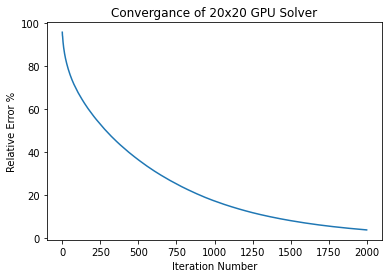

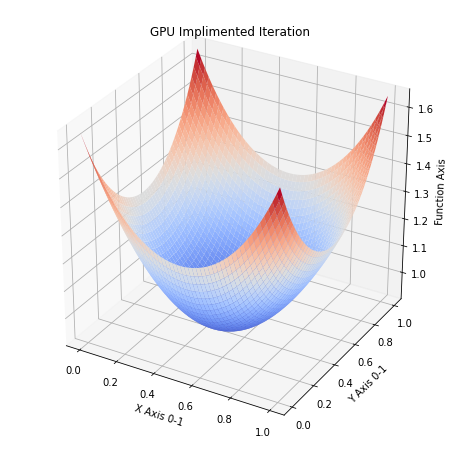

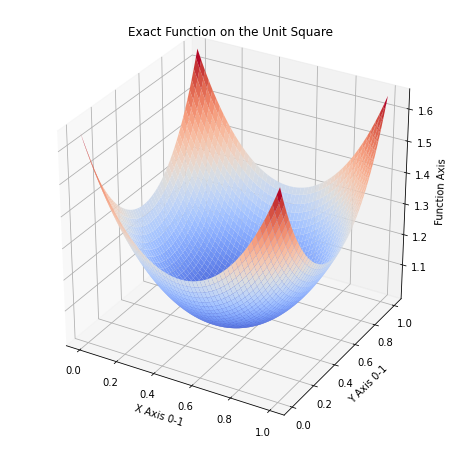

In [ ]:
N = 200
u,f = grid_discretise(N, u_deriv_calc, u_exact_calc) 
u_exact = get_exact_vector(N)

error_list = []
TPB = 16
BPG = (N+TPB-1)//TPB

u_to_GPU = cuda.to_device(u)
f_to_GPU = cuda.to_device(f)
u1_to_GPU = cuda.to_device(u)

for iterate in range(2000):
  single_GPU_iteration[(TPB,1),(BPG,1)](u_to_GPU,f_to_GPU, u1_to_GPU, N)
  error_list.append(100*error_calc(u1_to_GPU.copy_to_host().reshape((N,N)), 
                                   u_exact))

u1_from_GPU = u1_to_GPU.copy_to_host() 
print("Relative Error is : ", 100*error_calc(u1_from_GPU.reshape((N,N)), 
                                             u_exact),"%")
plt.plot(np.arange(0,2000,1), error_list)
plt.title("Convergance of 20x20 GPU Solver")
plt.xlabel("Iteration Number")
plt.ylabel("Relative Error %")
plot(u1_from_GPU.reshape(N,N) , "GPU Implimented Iteration", True, N)

The above graph clearly shows convergance to 0 error over 2000 iterations, and the graph of the function looks very close to the exact function. Since this has performed well, the next task will benchmark it against other function from above - the iterative.

Text(0.5, 1.0, 'Convergance for Iterative vs GPU N=20')

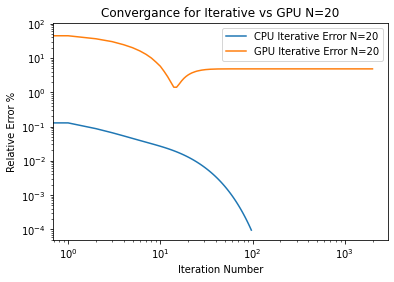

In [ ]:
N=10
range_n = 2000
plt.loglog(find_solution(N, range_n, 0.0001, u_deriv_calc, u_exact_calc, 
                         False)[2], label = "CPU Iterative Error N=20")

u,f = grid_discretise(N, u_deriv_calc, u_exact_calc) 
u_exact = get_exact_vector(N)
error_list = []
TPB = 16
BPG = (N+TPB-1)//TPB
u_to_GPU = cuda.to_device(u)
f_to_GPU = cuda.to_device(f)
u1_to_GPU = cuda.to_device(u)
for iterate in range(range_n):
  single_GPU_iteration[(TPB,1),(BPG,1)](u_to_GPU,f_to_GPU, u1_to_GPU, N)
  error_list.append(100*error_calc(u1_to_GPU.copy_to_host().reshape((N,N)), 
                                   u_exact))
u1_from_GPU = u1_to_GPU.copy_to_host() 
plt.loglog(np.arange(0,range_n,1), error_list, label="GPU Iterative Error N=20")

plt.legend()
plt.xlabel("Iteration Number")
plt.ylabel("Relative Error %")
plt.title("Convergance for Iterative vs GPU N=20")

Here the GPU is much less accurate than the CPU. Infact, the CPU converges to the neccessary 10$^{-4}$ in a fraction of the iterations as the GPU. At 100 iterations CPU has reached its goal while the GPU is still error $\approx$ 10. However, what is more interesting is the kink in the GPU convergance (it diverges) around iteration 15. The researcher does not know what may couse this apart from a program bug.  

To see if it is a recurring issue, and because GPU may outperform over larger NxN matrices, we expand this experiment to a 100x100 matrix. We obtain similar results, however the GPU performs noticably better. This may simply be due to the iterative method reaching its maximum iterations after running for ~5 min, as evidenced by the output "NOT ENOUGH ITERATIONS...GIVE ME MORE NUMBERS!!".

NOT ENOUGH ITERATIONS...GIVE ME MORE NUMBERS!!


Text(0.5, 1.0, 'Convergance for Iterative vs GPU N=100')

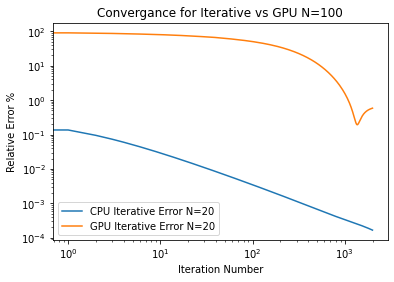

In [ ]:
N=100
range_n = 2000
plt.loglog(find_solution(N, range_n, 0.0001, u_deriv_calc, u_exact_calc, 
                         False)[2], label = "CPU Iterative Error N=20")

u,f = grid_discretise(N, u_deriv_calc, u_exact_calc) 
u_exact = get_exact_vector(N)
error_list = []
TPB = 16
BPG = (N+TPB-1)//TPB
u_to_GPU = cuda.to_device(u)
f_to_GPU = cuda.to_device(f)
u1_to_GPU = cuda.to_device(u)
for iterate in range(range_n):
  single_GPU_iteration[(TPB,1),(BPG,1)](u_to_GPU,f_to_GPU, u1_to_GPU, N)
  error_list.append(100*error_calc(u1_to_GPU.copy_to_host().reshape((N,N)), 
                                   u_exact))
u1_from_GPU = u1_to_GPU.copy_to_host() 
plt.loglog(np.arange(0,range_n,1), error_list, label="GPU Iterative Error N=20")

plt.legend()
plt.xlabel("Iteration Number")
plt.ylabel("Relative Error %")
plt.title("Convergance for Iterative vs GPU N=100")

# Conclusion

The Discretize function was successful, approximating a 200x200 matrix to 0.12%. The error follows a exponential decay relation with matrix size, as the step size grows in 2D (making the areas not covered by a discrete point smaller). This method solves the matrix equation $Au = f$.

The Iterative method was used to correctly approximate a 50x50 matrix to within 1e-6 relative iteration error in 3559 iterations. This method uses $u_{k}(x_{i},y_{j}) => u_{k+1}(x_{i},y_{j})$ iteration from k -> k+1.

The GPU created an approximation which was accurate tp 3% for a 200x200 matrix. It did not perform as accurately as expected, nor did it converge as fast. This is likely due to the implementation of the code, rather than cuda itself. 

